In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.io as scio
from scipy.optimize import root
from matplotlib.font_manager import FontProperties

font_path = r'C:\Windows\Fonts\simsun.ttc'
chinese_font = FontProperties(fname=r'C:\Windows\Fonts\simsun.ttc')
english_font = FontProperties(fname=r'C:\Windows\Fonts\times.ttf')

rural = np.arange(0, 60, 2)
urban = np.arange(1, 60, 2)
east = np.r_[0, 1, 2, 3, 4, 5, 16, 17, 18, 19, 20, 21, 24, 25, 28, 29, 36, 37, 40, 41]
middle = np.r_[6, 7, 22, 23, 26, 27, 30, 31, 32, 33, 34, 35]
west = np.r_[8, 9, 10, 11, 12, 13, 14, 15, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

In [2]:
# 读取基准情形的变量和参数
equilibrium2010 = np.load('./data/equilibrium2010.npz')
R = equilibrium2010['R']
X = equilibrium2010['X']
m = equilibrium2010['m']
pi = equilibrium2010['pi']
L = equilibrium2010['L']
L_bar = equilibrium2010['L_bar']
K = equilibrium2010['K']
w = equilibrium2010['w']
P = equilibrium2010['P']
W = equilibrium2010['W']

parameter = np.load('./data/Parameter.npz')
kappa = parameter['kappa']
theta = parameter['theta']
beta = parameter['beta']
psi_ag = parameter['psi_ag']
psi_na = parameter['psi_na']
alpha_ag = parameter['alpha_ag']
alpha_na = parameter['alpha_na']
sigma_ag = parameter['sigma_ag']
sigma_na = parameter['sigma_na']
eta_ag_ag = parameter['eta_ag_ag']
eta_ag_na = parameter['eta_ag_na']
eta_na_ag = parameter['eta_na_ag']
eta_na_na = parameter['eta_na_na']
phiu = parameter['phiu']
phip = parameter['phip']
chi = parameter['chi']
eta = parameter['eta']
delta = parameter['delta']
xi_ag = parameter['xi_ag']
xi_na = parameter['xi_na']
t = parameter['t']

In [3]:
# 导入外生变量的反事实变化

## 保持各外生变量均不变
dKp = np.ones([60, 1])
dKh = np.ones([60, 1])
dT = np.ones([60, 1])
dtau = np.ones([60, 60])
dmu = np.ones([60, 60])

In [4]:
# 定义求解反事实均衡的函数

def SolveCounter(XX):
    dw = XX[:60].reshape([60, 1])
    dL = XX[60:120].reshape([60, 1])
    dp = XX[120:].reshape([60, 1])

    ## (a)价格指数的变化
    dpdp_wp_c = np.repeat((dp.reshape([30, 2]) ** np.array([psi_ag * beta, psi_na * beta]).reshape([1, 2])).prod(axis=1).reshape([30, 1]), 2, axis=1).reshape([60, 1])
    drh = dw * dL / dKh
    dP =  dpdp_wp_c *  (drh ** (1 - beta))

    ## (b)公共支出的变化
    dG = dw * dL / dP

    ## (c)单位投入束成本的相对变化
    dw_wp = (dw.reshape([30, 2]) ** np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1])
    drp = dw * dL / dKp
    drp_wp = (drp.reshape([30, 2]) ** np.array([sigma_ag, sigma_na]).reshape([1, 2])).reshape([60, 1])
    dpdp_wp_p_ag = (dp.reshape([30, 2]) ** np.array([eta_ag_ag, eta_na_ag]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p_na = (dp.reshape([30, 2]) ** np.array([eta_ag_na, eta_na_na]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p = np.concatenate([dpdp_wp_p_ag, dpdp_wp_p_na], axis=1).reshape([60, 1])
    dc = dw_wp * drp_wp * dpdp_wp_p

    ## (d)贸易份额的相对变化
    dpi_num = dT * ((dtau * dc) ** (-theta)) * (dG ** (phip * theta)) * (dL ** (theta * delta)) # 分子(考虑生产函数中存在规模经济效应)
    dpi_den = (dpi_num * pi).sum(axis=0).reshape([60, 1]) # 分母
    dpi = (dpi_num.T / dpi_den).T
    pi_prime = pi * dpi # 反事实情形下的贸易份额

    ## (e)最终品价格的相对变化
    dp1 = dpi_den ** (-1 / theta)

    ## (f)收入倍率的相对变化
    wL = (R.reshape([30, 2]) * np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1]) # 计算总工资收入
    w = wL / L # 名义工资收入
    w_prime = w * dw
    coef_rK_ag = (alpha_ag + sigma_ag - (beta + t - beta * t) * alpha_ag) / ((beta + t - beta * t) * alpha_ag)
    coef_rK_na = sigma_na / alpha_na + (1 - beta) * (1 - t)
    rKrK = (wL.reshape([30, 2]) * np.array([coef_rK_ag, coef_rK_na]).reshape([1, 2])).reshape([60, 1])  # 计算出城市部门和农村部门的土地总收入
    rho_prime = rKrK * dw * dL / L_bar # 土地改革后，户籍居民的人均土地收入
    rho_prime[1::2] = 0 # 城市部门居民没有土地收入，所以将偶数行替换为0
    delta_prime = 1 + (w_prime ** (-1)) @ rho_prime.T # 改革后的收入倍率
    delta_diag = ((L / (L_bar * np.diag(m).reshape([60, 1]))).reshape([30, 2]) * np.array([coef_rK_ag, 0]).reshape([1, 2]) + 1).reshape([60, 1]) # 计算delta的主对角线元素
    ddelta = delta_prime # ddelta和delta_prime的非主对角线元素是一样的
    np.fill_diagonal(ddelta, np.diag(delta_prime).reshape([60, 1]) / delta_diag) # 计算并替换ddelta的主对角线元素

    ## (g)流动份额的相对变化
    dg = dG / (dL ** chi) # 人均公共支出的相对变化
    dW = dw / dP # 实际工资的相对变化
    dm_num = (ddelta * (dmu ** (-1)) * (dg ** phiu) * dW) ** kappa # 分子
    dm_den = (dm_num * m).sum(axis=0).reshape([60, 1]) # 分母
    dm = (dm_num.T / dm_den).T
    m_prime = m * dm

    ## (h)常住人口数的相对变化
    dL1 = (m_prime @ L_bar) / L

    ## (i)计算反事实下的总产出与总支出
    R_prime = R * dw * dL
    wL_prime = wL * dw * dL
    X_prime = np.linalg.inv(pi_prime) @ R_prime ## 根据总产出R_prime计算出的总支出X_prime
    vL_prime = (wL_prime.reshape([30, 2]) * np.array([(alpha_ag + sigma_ag) / (beta + t - beta * t) / alpha_ag, 1]).reshape([1, 2])).reshape([60, 1])
    PG_prime = (wL_prime.reshape([30, 2]) * np.array([t * (alpha_ag + sigma_ag) / (beta + t - beta * t) / alpha_ag, 1 - beta + sigma_na / alpha_na + beta * t]).reshape([1, 2])).reshape([60, 1])
    A_prime = (beta * (1 - t) * np.repeat(vL_prime.reshape([30, 2]).sum(axis=1).reshape([30, 1]), 2, axis=1) * np.array([psi_ag, psi_na]).reshape([1, 2])).reshape([60, 1])
    C_prime = (np.repeat(PG_prime.reshape([30, 2]).sum(axis=1).reshape([30, 1]), 2, axis=1) * np.array([xi_ag, xi_na]).reshape([1, 2])).reshape([60, 1])
    B_ag_prime = ((R_prime.reshape([30, 2]) * np.array([eta_ag_ag, eta_ag_na]).reshape([1, 2])).sum(axis=1)).reshape([30, 1])
    B_na_prime = ((R_prime.reshape([30, 2]) * np.array([eta_na_ag, eta_na_na]).reshape([1, 2])).sum(axis=1)).reshape([30, 1])
    B_prime = np.concatenate([B_ag_prime, B_na_prime], axis=1).reshape([60, 1])
    X_prime1 = A_prime + B_prime + C_prime ## 根据各项支出计算出的总支出X_prime1，均衡下应该与前面的X_prime相等

    ## (j)均衡条件
    res1 = dp1 - dp
    res2 = dL1 - dL
    res3 = X_prime1 - X_prime

    return np.concatenate([res1, res2, res3]).flatten().astype(float)

In [5]:
# 定义储存反事实变量的函数
def counterfautual_result(dw, dL, dp):
    dpdp_wp_c = np.repeat((dp.reshape([30, 2]) ** np.array([psi_ag * beta, psi_na * beta]).reshape([1, 2])).prod(axis=1).reshape([30, 1]), 2, axis=1).reshape([60, 1])
    drh = dw * dL / dKh
    dP =  dpdp_wp_c *  (drh ** (1 - beta))
    dG = dw * dL / dP
    dw_wp = (dw.reshape([30, 2]) ** np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1])
    drp = dw * dL / dKp
    drp_wp = (drp.reshape([30, 2]) ** np.array([sigma_ag, sigma_na]).reshape([1, 2])).reshape([60, 1])
    dpdp_wp_p_ag = (dp.reshape([30, 2]) ** np.array([eta_ag_ag, eta_na_ag]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p_na = (dp.reshape([30, 2]) ** np.array([eta_ag_na, eta_na_na]).reshape([1, 2])).prod(axis=1).reshape([30, 1])
    dpdp_wp_p = np.concatenate([dpdp_wp_p_ag, dpdp_wp_p_na], axis=1).reshape([60, 1])
    dc = dw_wp * drp_wp * dpdp_wp_p
    dpi_num = dT * ((dtau * dc) ** (-theta)) * (dG ** (phip * theta)) * (dL ** (theta * delta)) # 分子(考虑生产函数中存在规模经济效应)
    dpi_den = (dpi_num * pi).sum(axis=0).reshape([60, 1]) # 分母
    dpi = (dpi_num.T / dpi_den).T
    pi_prime = pi * dpi # 反事实情形下的贸易份额
    wL = (R.reshape([30, 2]) * np.array([alpha_ag, alpha_na]).reshape([1, 2])).reshape([60, 1]) # 计算总工资收入
    w = wL / L # 名义工资收入
    w_prime = w * dw
    coef_rK_ag = (alpha_ag + sigma_ag - (beta + t - beta * t) * alpha_ag) / ((beta + t - beta * t) * alpha_ag)
    coef_rK_na = sigma_na / alpha_na + (1 - beta) * (1 - t)
    rKrK = (wL.reshape([30, 2]) * np.array([coef_rK_ag, coef_rK_na]).reshape([1, 2])).reshape([60, 1])  # 计算出城市部门和农村部门的土地总收入
    rho_prime = rKrK * dw * dL / L_bar # 土地改革后，户籍居民的人均土地收入
    rho_prime[1::2] = 0 # 城市部门居民没有土地收入，所以将偶数行替换为0
    delta_prime = 1 + (w_prime ** (-1)) @ rho_prime.T # 改革后的收入倍率
    delta_diag = ((L / (L_bar * np.diag(m).reshape([60, 1]))).reshape([30, 2]) * np.array([coef_rK_ag, 0]).reshape([1, 2]) + 1).reshape([60, 1]) # 计算delta的主对角线元素
    ddelta = delta_prime # ddelta和delta_prime的非主对角线元素是一样的
    np.fill_diagonal(ddelta, np.diag(delta_prime).reshape([60, 1]) / delta_diag) # 计算并替换ddelta的主对角线元素
    dg = dG / (dL ** chi) # 人均公共支出的相对变化
    dW = dw / dP # 实际工资的相对变化
    dm_num = (ddelta * (dmu ** (-1)) * (dg ** phiu) * dW) ** kappa # 分子
    dm_den = (dm_num * m).sum(axis=0).reshape([60, 1]) # 分母
    dm = (dm_num.T / dm_den).T
    m_prime = m * dm
    R_prime = R * dw * dL
    X_prime = np.linalg.inv(pi_prime) @ R_prime ## 根据总产出R_prime计算出的总支出X_prime

    return dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime, delta_diag

In [6]:
XX = root(SolveCounter, x0=np.ones(3*60), method='lm') # 求解非线性方程组
dw = XX.x[:60].reshape([60, 1])
dL = XX.x[60:120].reshape([60, 1])
dp = XX.x[120:].reshape([60, 1])
dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime, delta_diag = counterfautual_result(dw, dL, dp)
W = w / P
w_prime = w * dw
L_prime = L * dL
P_prime = P * dP
W_prime = w_prime / P_prime

NameError: name 'delta' is not defined

In [7]:
# 定义计算福利效应的函数
def welfare():
    coef_g_na = 1 - beta + sigma_na / alpha_na + beta * t
    coef_g_ag = (alpha_ag + sigma_ag) * t / (beta + t - beta * t) / alpha_ag
    g = ((w * L).reshape([30, 2]) * np.array([coef_g_ag, coef_g_na]).reshape([1, 2])).reshape([60, 1]) / P / (L ** chi)
    
    dV = dW * ((dg) ** phiu) * (np.diag(dm).reshape([-1, 1]) ** (-1 / kappa)) * (np.diag(ddelta).reshape([-1, 1]))

    weight = (np.diag(m).reshape([-1, 1]) ** (-1 / kappa)) * (g ** phiu) * W * L_bar * delta_diag
    weight_country = weight / weight.sum()
    weight_urban = weight[urban] / weight[urban].sum()
    weight_rural = weight[rural] / weight[rural].sum()
    weight_east = weight[east] / weight[east].sum()
    weight_middle = weight[middle] / weight[middle].sum()
    weight_west = weight[west] / weight[west].sum()

    dV_country = ((dV * weight_country).sum() - 1) * 100
    dV_urban = ((dV[urban] * weight_urban).sum() - 1) * 100
    dV_rural = ((dV[rural] * weight_rural).sum() - 1) * 100
    dV_east = ((dV[east] * weight_east).sum() - 1) * 100
    dV_middle = ((dV[middle] * weight_middle).sum() - 1) * 100
    dV_west = ((dV[west] * weight_west).sum() - 1) * 100
    
    return dV, dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west

In [8]:
# 基准情形下的福利效应
XX = root(SolveCounter, x0=np.ones(3*60), method='lm') # 求解非线性方程组
dw = XX.x[:60].reshape([60, 1])
dL = XX.x[60:120].reshape([60, 1])
dp = XX.x[120:].reshape([60, 1])
dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime, delta_diag = counterfautual_result(dw, dL, dp)
W = w / P
w_prime = w * dw
L_prime = L * dL
P_prime = P * dP
W_prime = w_prime / P_prime

dV, dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west = welfare()

table_baseline = pd.DataFrame([dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west]).T.round(3)
table_baseline.columns = ['全国', '城市', '农村', '东部', '中部', '西部']
table_baseline

NameError: name 'delta' is not defined

In [21]:
# 仍留在户籍所在地的户籍居民福利变化

coef_g_na = 1 - beta + sigma_na / alpha_na + beta * t
coef_g_ag = (alpha_ag + sigma_ag) * t / (beta + t - beta * t) / alpha_ag
g_urban = (w * L / P)[urban] * coef_g_na / (L[urban] ** chi)
g_rural = (w * L / P)[rural] * coef_g_ag / (L[rural] ** chi)
g = np.concatenate([g_rural, g_urban], axis=1).reshape([60, 1])
g_prime_urban = (w_prime * L_prime / P_prime)[urban] * coef_g_na / (L_prime[urban] ** chi)
g_prime_rural = (w_prime * L_prime / P_prime)[rural] * coef_g_ag / (L_prime[rural] ** chi)
g_prime = np.concatenate([g_prime_rural, g_prime_urban], axis=1).reshape([60, 1])

Vii = (g ** phiu) * W * delta_diag
Vii_prime = (g_prime ** phiu) * W_prime * (delta_diag * np.diag(ddelta).reshape([60, 1]))
Lii_prime = L_bar * np.diag(m_prime).reshape([60, 1])

dVii_country = ((Vii_prime * Lii_prime).sum() / (Vii * Lii_prime).sum() - 1) * 100
dVii_urban = ((Vii_prime[urban] * Lii_prime[urban]).sum() / (Vii[urban] * Lii_prime[urban]).sum() - 1) * 100
dVii_rural = ((Vii_prime[rural] * Lii_prime[rural]).sum() / (Vii[rural] * Lii_prime[rural]).sum() - 1) * 100
dVii_east = ((Vii_prime[east] * Lii_prime[east]).sum() / (Vii[east] * Lii_prime[east]).sum() - 1) * 100
dVii_middle = ((Vii_prime[middle] * Lii_prime[middle]).sum() / (Vii[middle] * Lii_prime[middle]).sum() - 1) * 100
dVii_west = ((Vii_prime[west] * Lii_prime[west]).sum() / (Vii[west] * Lii_prime[west]).sum() - 1) * 100

table_local = pd.DataFrame([dVii_country, dVii_urban, dVii_rural, dVii_east, dVii_middle, dVii_west]).T.round(3)
table_local.columns = ['全国', '城市', '农村', '东部', '中部', '西部']
table_local

,全国,城市,农村,东部,中部,西部
0,-4.696,-2.922,-8.209,-5.724,-4.988,-3.005


In [22]:
# 流动人口的福利变化

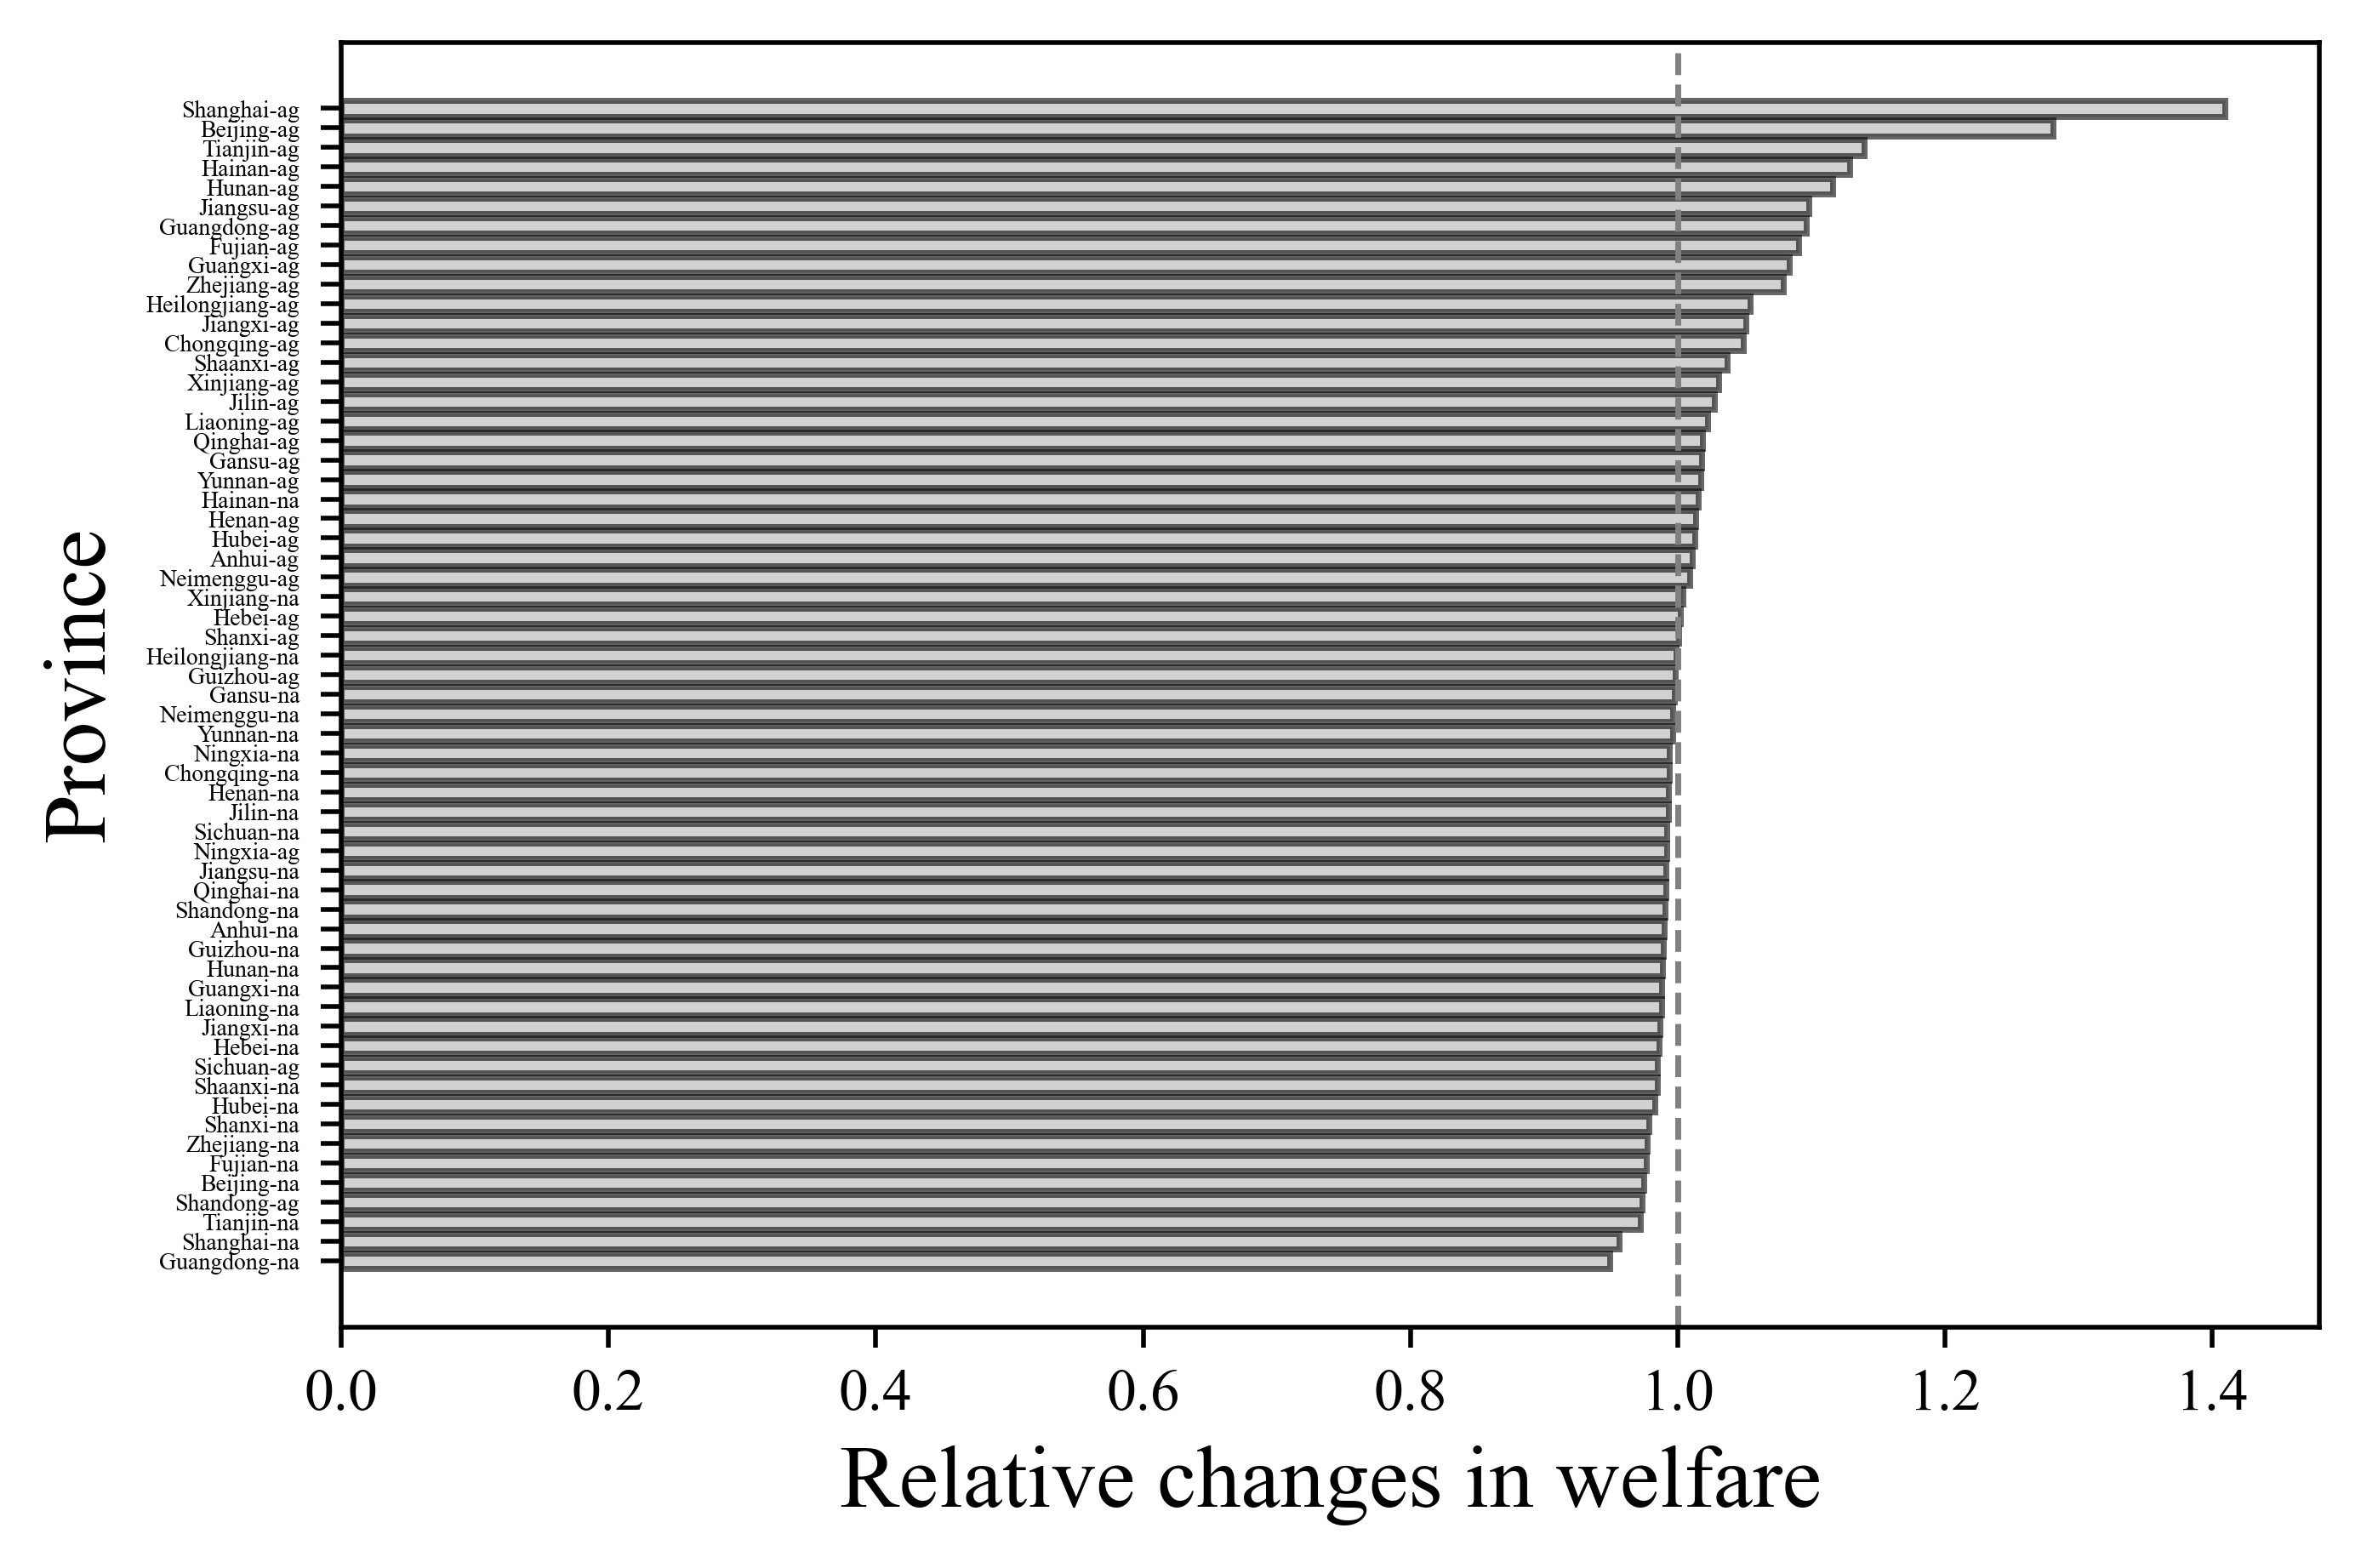

In [23]:
# 画图查看基准情形下各地区各部门的户籍居民福利变化
dV1 = list((dV).flatten())
prov = ['Beijing', 'Tianjin', 'Hebei', 'Shanxi', 'Neimenggu', 'Liaoning', 'Jilin', 'Heilongjiang', 'Shanghai', 'Jiangsu', 'Zhejiang', 'Anhui', 'Fujian', 'Jiangxi', 'Shandong', 'Henan', 'Hubei', 'Hunan', 'Guangdong', 'Guangxi', 'Hainan', 'Chongqing', 'Sichuan', 'Guizhou', 'Yunnan', 'Shaanxi', 'Gansu', 'Qinghai', 'Ningxia', 'Xinjiang']
prov_sector = []
for each_prov in prov:
    prov_sector.append(each_prov + '-ag')
    prov_sector.append(each_prov + '-na')

welfare_df = pd.DataFrame({'prov-sector' : prov_sector, 'dV' : dV1})
welfare_df = welfare_df.sort_values(by='dV')
welfare_df = welfare_df.reset_index(drop=True)

fig, ax = plt.subplots(dpi=500)
ax.barh(welfare_df['prov-sector'], welfare_df['dV'], edgecolor='black', color='0.7', alpha=0.6)
ax.set_xlabel('Relative changes in welfare', size=15, fontproperties=english_font) # size=20
ax.set_ylabel('Province', size=15, fontproperties=english_font) # size=20
ax.axvline(1, color='0.5', ls='--', lw=1)

for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontproperties(english_font)
plt.yticks(fontsize=4)
plt.show()

In [24]:
# 公共品拥挤效应：无拥挤效应chi=0
chi = 0
XX = root(SolveCounter, x0=np.ones(3*60), method='lm') # 求解非线性方程组
dw = XX.x[:60].reshape([60, 1])
dL = XX.x[60:120].reshape([60, 1])
dp = XX.x[120:].reshape([60, 1])
dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime,delta_diag = counterfautual_result(dw, dL, dp)
W = w / P
w_prime = w * dw
L_prime = L * dL
P_prime = P * dP
W_prime = w_prime / P_prime

dV, dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west = welfare()

table_chi0 = pd.DataFrame([dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west]).T.round(3)
table_chi0.columns = ['全国', '城市', '农村', '东部', '中部', '西部']
table_chi0

,全国,城市,农村,东部,中部,西部
0,1.619,-1.354,4.82,2.175,1.473,0.775


In [25]:
# 公共品拥挤效应：较大拥挤效应chi=1
chi = 1
XX = root(SolveCounter, x0=np.ones(3*60), method='lm') # 求解非线性方程组
dw = XX.x[:60].reshape([60, 1])
dL = XX.x[60:120].reshape([60, 1])
dp = XX.x[120:].reshape([60, 1])
dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime,delta_diag = counterfautual_result(dw, dL, dp)
W = w / P
w_prime = w * dw
L_prime = L * dL
P_prime = P * dP
W_prime = w_prime / P_prime

dV, dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west = welfare()

table_chi1 = pd.DataFrame([dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west]).T.round(3)
table_chi1.columns = ['全国', '城市', '农村', '东部', '中部', '西部']
table_chi1

,全国,城市,农村,东部,中部,西部
0,1.673,-1.722,5.144,2.358,1.468,0.689


In [26]:
# 房价效应：无住房支出
chi = 0.9 ## 将chi调整回基准取值
beta = 0.99
XX = root(SolveCounter, x0=np.ones(3*60), method='lm') # 求解非线性方程组
dw = XX.x[:60].reshape([60, 1])
dL = XX.x[60:120].reshape([60, 1])
dp = XX.x[120:].reshape([60, 1])
dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime,delta_diag = counterfautual_result(dw, dL, dp)
W = w / P
w_prime = w * dw
L_prime = L * dL
P_prime = P * dP
W_prime = w_prime / P_prime

dV, dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west = welfare()

table_beta99 = pd.DataFrame([dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west]).T.round(3)
table_beta99.columns = ['全国', '城市', '农村', '东部', '中部', '西部']
table_beta99

,全国,城市,农村,东部,中部,西部
0,1.469,-1.345,4.567,1.992,1.253,0.768


In [27]:
# 房价效应：高住房支出
beta = 0.8
XX = root(SolveCounter, x0=np.ones(3*60), method='lm') # 求解非线性方程组
dw = XX.x[:60].reshape([60, 1])
dL = XX.x[60:120].reshape([60, 1])
dp = XX.x[120:].reshape([60, 1])
dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime,delta_diag = counterfautual_result(dw, dL, dp)
W = w / P
w_prime = w * dw
L_prime = L * dL
P_prime = P * dP
W_prime = w_prime / P_prime

dV, dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west = welfare()

table_beta80 = pd.DataFrame([dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west]).T.round(3)
table_beta80.columns = ['全国', '城市', '农村', '东部', '中部', '西部']
table_beta80

,全国,城市,农村,东部,中部,西部
0,2.0,-2.262,5.985,2.922,1.789,0.612


In [28]:
# 规模经济效应效应：较小的规模经济效应delta=0.01
chi = 0.9 ## 将chi调整回基准取值
beta = 0.9 ## 将beta调整回基准取值
delta = 0.01
XX = root(SolveCounter, x0=np.ones(3*60), method='lm') # 求解非线性方程组
dw = XX.x[:60].reshape([60, 1])
dL = XX.x[60:120].reshape([60, 1])
dp = XX.x[120:].reshape([60, 1])
dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime,delta_diag = counterfautual_result(dw, dL, dp)
W = w / P
w_prime = w * dw
L_prime = L * dL
P_prime = P * dP
W_prime = w_prime / P_prime

dV, dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west = welfare()

table_delta01 = pd.DataFrame([dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west]).T.round(3)
table_delta01.columns = ['全国', '城市', '农村', '东部', '中部', '西部']
table_delta01

,全国,城市,农村,东部,中部,西部
0,1.966,-1.396,5.421,2.731,1.675,0.919


In [29]:
# 规模经济效应效应：较大的规模经济效应delta=0.1
chi = 0.9 ## 将chi调整回基准取值
delta = 0.10
XX = root(SolveCounter, x0=np.ones(3*60), method='lm') # 求解非线性方程组
dw = XX.x[:60].reshape([60, 1])
dL = XX.x[60:120].reshape([60, 1])
dp = XX.x[120:].reshape([60, 1])
dg, dc, dpi, pi_prime, dP, ddelta, dW, dm, m_prime, R_prime, X_prime,delta_diag = counterfautual_result(dw, dL, dp)
W = w / P
w_prime = w * dw
L_prime = L * dL
P_prime = P * dP
W_prime = w_prime / P_prime

dV, dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west = welfare()

table_delta10 = pd.DataFrame([dV_country, dV_urban, dV_rural, dV_east, dV_middle, dV_west]).T.round(3)
table_delta10.columns = ['全国', '城市', '农村', '东部', '中部', '西部']
table_delta10

,全国,城市,农村,东部,中部,西部
0,4.891,1.418,8.46,7.158,3.065,2.666


In [30]:
# 生成表格
table = pd.DataFrame() # 初始化表格
table = table.append(
        [table_baseline, table_chi0, table_chi1, table_beta99, table_beta80, table_delta01, table_delta10, table_local], 
    ignore_index=True)
table.index = ['基准情形', '无拥挤效应$\chi=0$', '较大的拥挤效应$\chi=1$', '较低的住房支出$\\beta=0.99$', '较高的住房支出$\\beta=0.8$', '较小的规模经济效应$\delta=0.01$', '较大的规模经济效应$\delta=0.1$', '仍留在户籍所在地的户籍居民福利变化']
table

,全国,城市,农村,东部,中部,西部
基准情形,1.664,-1.689,5.108,2.331,1.468,0.698
无拥挤效应$\chi=0$,1.619,-1.354,4.820,2.175,1.473,0.775
较大的拥挤效应$\chi=1$,1.673,-1.722,5.144,2.358,1.468,0.689
较低的住房支出$\beta=0.99$,1.469,-1.345,4.567,1.992,1.253,0.768
较高的住房支出$\beta=0.8$,2.000,-2.262,5.985,2.922,1.789,0.612
较小的规模经济效应$\delta=0.01$,1.966,-1.396,5.421,2.731,1.675,0.919
较大的规模经济效应$\delta=0.1$,4.891,1.418,8.460,7.158,3.065,2.666
仍留在户籍所在地的户籍居民福利变化,-4.696,-2.922,-8.209,-5.724,-4.988,-3.005
